# Introduction

**Project Title**  
*Supervised Learning: Model Quality*  

**Research Description**  
The online store *"One Click"* has faced a decline in customer activity. The company's management decided to develop a personalized offer system for loyal customers based on data analysis and customer behavior prediction.  

**Research Goal**  
To develop a machine learning model that predicts the probability of declining customer activity, identifies customer segments, and suggests retention strategies.  

**Research Objectives**  
- **Data Analysis**: customer behavior, marketing communications, financial indicators.  
- **Data Preprocessing**: cleaning, handling missing values, type conversion.  
- **Model Building**: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC.  
- **Feature Importance Evaluation** for the best model.  
- **Customer Segmentation** and analysis of their characteristics.  
- **Recommendation Development** for customer retention.  

---  

**Source Data**  

Used tables:  
- `market_file.csv` — customer behavior on the website, communications, and product interactions.  
- `market_money.csv` — revenue data per customer.  
- `market_time.csv` — time spent on the website.  
- `money.csv` — average profit per customer over 3 months.  

---  

**Research Structure**  
**[1. Data Loading and Initial Analysis](#section_1)**  
* Exploring files and data structure  
* Checking formats and missing values  
    
**[2. Data Preprocessing](#section_2)**  
* Cleaning  
* Handling missing values  
* Type conversion  

**[3. Exploratory Data Analysis](#section_3)**  
* Distribution analysis  
* Correlation assessment  

**[4. Data Merging](#section_4)**  
* Table preparation  
* Table merging  

**[5. Correlation Analysis](#section_5)**  
* Building and analyzing a correlation matrix  

**[6. Model Training Pipeline](#section_6)**  
* Data preparation  
* Training and hyperparameter tuning  
* Selecting the best model  

**[7. Feature Importance Analysis](#section_7)**  
* Significance evaluation using **SHAP**  

**[8. Customer Segmentation and Strategy Development](#section_8)**  
* Identifying segments  
* Analyzing characteristics  
* Developing personalized offers  

**[9. Final Conclusions](#section_9)**  
* Best model  
* Final recommendations for customer retention  

---  

🚀 This research will help the *"One Click"* online store improve the effectiveness of personalized offers, retain loyal customers, and increase revenue.  

In [73]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [74]:
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [75]:
%pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [76]:
%pip install matplotlib==3.5.1 -q

Note: you may need to restart the kernel to use updated packages.


In [77]:
%pip install --upgrade scipy -q

Note: you may need to restart the kernel to use updated packages.


In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import phik

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.datasets import make_classification

In [79]:
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)

<a id="section_1"></a>
## Data loading

### File loading

In [80]:
market = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';')

### Data info

In [81]:
for df in [market, market_money, market_time, money]:
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


### Сonclusion

<div class="alert alert-info">
I have read the data, and we have four tables:  

1. **market_file** - Customer behavior data on the website.  
2. **market_money** - Revenue data per customer for the last three months.  
3. **market_time** - Time spent on the website by customers over the last two months.  
4. **money** - Average monthly profit per customer over the last three months.  

All these tables are linked through the customer ID and contain a multiple of 1300 rows, meaning we have 1300 users.  

Overall, the data aligns with the column names, but some contain errors, such as `"предыдцщий_месяц"`. I will correct them in the next steps.

<a id="section_2"></a>
## Data preprocessing

In [82]:
print(market['id'].nunique()) # Checking for duplicate IDs, result: none found.

1300


### Column names

In [83]:
def normalize_col_names(col_names):
    return[col.lower().replace(' ', '_') for col in col_names]

In [84]:
for df in [market, market_money, market_time, money]:
    print(df.columns)
    df.columns = normalize_col_names(df.columns)
    print(df.columns)
    print()

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')
Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Index(['id', 'Период', 'Выручка'], dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')

Index(['id', 'Период', 'минут'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')

Index(['id', 'Прибыль'], dtype='object')
Index(['id', 'прибыль'], dtype='object

### Data types

In [85]:
money['прибыль'] = money['прибыль'].replace(to_replace=',', value='.', regex=True)
money['прибыль'] = money['прибыль'].astype('float32')
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 15.4 KB


In [86]:
market = market.astype({'id':'int32', 'маркет_актив_тек_мес':'int32', 'длительность':'int32',
                          'средний_просмотр_категорий_за_визит':'int32','неоплаченные_продукты_штук_квартал':'int32',
                          'ошибка_сервиса':'int32', 'страниц_за_визит':'int32', 'маркет_актив_6_мес':'float32',
                          'акционные_покупки':'float32'})
market_money = market_money.astype({'id':'int32', 'выручка':'float32'})
market_time = market_time.astype({'id':'int32', 'минут':'int32'})

market.info()
market_money.info()
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int32  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float32
 5   маркет_актив_тек_мес                 1300 non-null   int32  
 6   длительность                         1300 non-null   int32  
 7   акционные_покупки                    1300 non-null   float32
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int32  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int32  
 11  ошибка_сервиса                

### Checking Categorical Data

In [87]:
display(market.head())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [88]:
for column_name in ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']:
    print(market[column_name].unique())
    market[column_name] = market[column_name].apply(lambda x: x.lower().replace(' ', '_'))
    print(market[column_name].unique())
    print()

['Снизилась' 'Прежний уровень']
['снизилась' 'прежний_уровень']

['премиум' 'стандартт' 'стандарт']
['премиум' 'стандартт' 'стандарт']

['да' 'нет']
['да' 'нет']

['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']



### Checking duplicates and correcting spelling

In [89]:
market['тип_сервиса'] = market['тип_сервиса'].replace('стандартт','стандарт')
print(market['тип_сервиса'].unique())

['премиум' 'стандарт']


In [90]:
print(market_money['период'].unique())
print(market_time['период'].unique())
market_money['период'] = market_money['период'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')
market_time['период'] = market_time['период'].replace('предыдцщий_месяц','предыдущий_месяц')
print(market_money['период'].unique())
print(market_time['период'].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']
['предпредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдущий_месяц']


### Сonclusion

<div class="alert alert-info">
    
Based on the information from the previous step, we can see that there are no explicit missing values, and the data types are correct, so no changes are necessary. I also confirmed that there are no duplicate users.

As a result:
1. I standardized column names to lowercase with underscores instead of spaces.
2. I converted the profit values in the finance table to the float type and optimized all numeric values to int32/float32.
3. I standardized the categorical data columns to lowercase with underscores instead of spaces.
4. I removed the duplicate service type 'стандартт' and corrected the period names.

<a id="section_3"></a>
## Exploratory Data Analysis

### money

In [91]:
# Started with the smaller and simpler ones
money['прибыль'].describe()

count    1300.000000
mean        3.996630
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

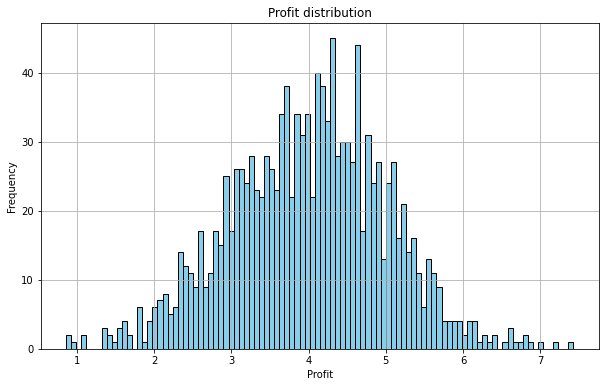

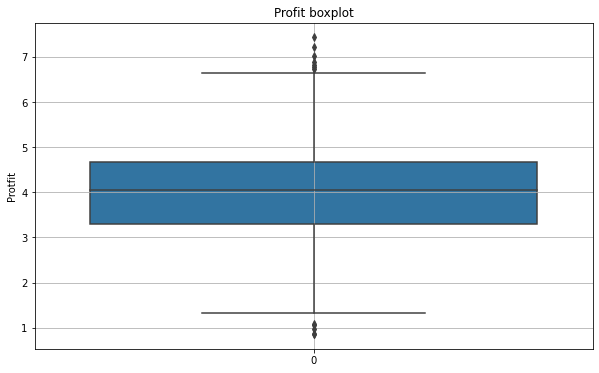

In [92]:
plt.figure(figsize=(10, 6))
plt.hist(money['прибыль'], bins=100, color='skyblue', edgecolor='black')
plt.title('Profit distribution')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=money['прибыль'])
plt.title('Profit boxplot')
plt.ylabel('Protfit')
plt.grid(True)
plt.show()

<div class="alert alert-info">
In the profit data table, the distribution is realistic, with only minor outliers, which also appear to be realistic.

### market_time

In [93]:
market_time.groupby('период')['минут'].describe()

,count,mean,std,min,25%,50%,75%,max
период,,,,,,,,
предыдущий_месяц,1300.0,13.467692,3.932029,5.0,11.0,13.0,17.0,23.0
текущий_месяц,1300.0,13.204615,4.220589,4.0,10.0,13.0,16.0,23.0


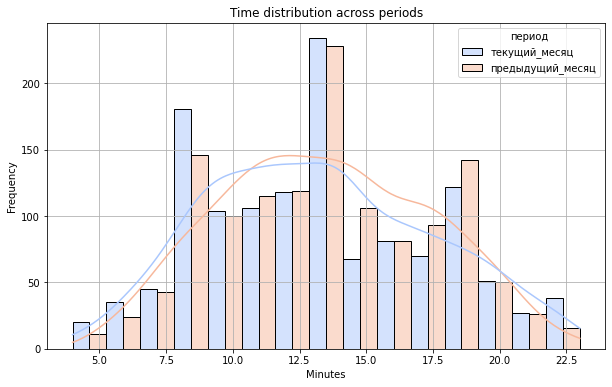

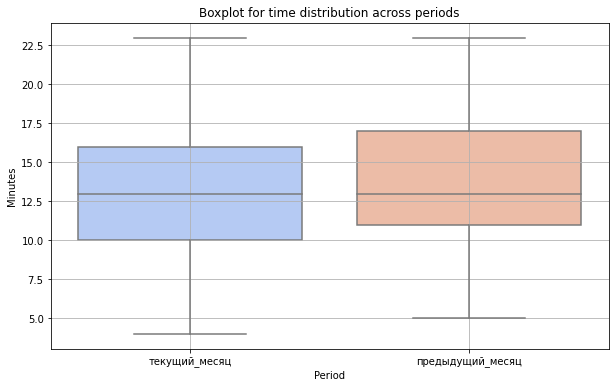

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(data=market_time, x='минут', hue='период', kde=True, bins=15, palette='coolwarm', multiple='dodge')
plt.title('Time distribution across periods')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='период', y='минут', data=market_time, palette='coolwarm')
plt.title('Boxplot for time distribution across periods')
plt.ylabel('Minutes')
plt.xlabel('Period')
plt.grid(True)
plt.show()

<div class="alert alert-info">

The time data table also looks fine and seems realistic, with no outliers. The data for the periods do not differ significantly, on average, users spent 0.26 minutes more on the site last month.

### market_money

In [95]:
display(market_money.groupby('период')['выручка'].describe())
display(market_money.head())

,count,mean,std,min,25%,50%,75%,max
период,,,,,,,,
предпредыдущий_месяц,1300.0,4825.207031,405.979675,0.000000,4583.000000,4809.000000,5053.500000,5663.000000
предыдущий_месяц,1300.0,4936.920410,739.597961,0.000000,4496.750000,5005.000000,5405.625000,6869.500000
текущий_месяц,1300.0,5314.960938,2939.708252,2758.699951,4706.050049,5179.949951,5761.724854,106862.203125


,id,период,выручка
0,215348,предпредыдущий_месяц,0.000000
1,215348,текущий_месяц,3293.100098
2,215348,предыдущий_месяц,0.000000
3,215349,предпредыдущий_месяц,4472.000000
4,215349,текущий_месяц,4971.600098


<div class="alert alert-info">
    
The maximum revenue for the current month seems quite high. It's possible that someone really made purchases worth 100k+, but it's strange that such a spike didn’t happen even remotely in the previous months. I need to check the profit from this customer to see if it has increased significantly.

In [96]:
print(market_money.query('выручка>100000'))

        id         период        выручка
98  215380  текущий_месяц  106862.203125


In [97]:
print(money.query('id == 215380'))

        id  прибыль
32  215380     3.88


In [98]:
market_money = market_money.query('выручка<100000')

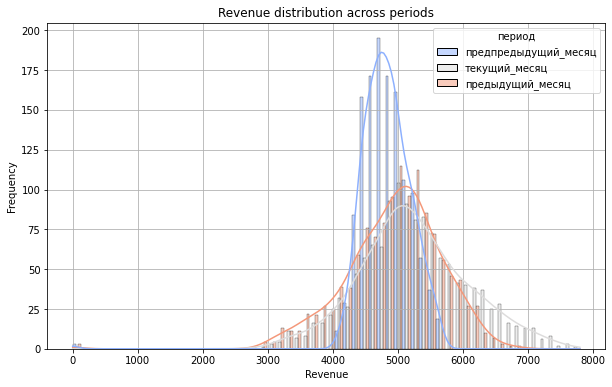

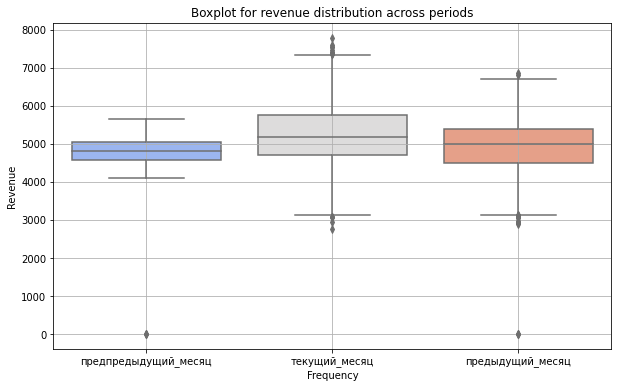

In [99]:
plt.figure(figsize=(10, 6))
sns.histplot(data=market_money, x='выручка', hue='период', kde=True, bins=60, palette='coolwarm', multiple="dodge")
plt.title('Revenue distribution across periods')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='период', y='выручка', data=market_money, palette='coolwarm')
plt.title('Boxplot for revenue distribution across periods')
plt.ylabel('Revenue')
plt.xlabel('Frequency')
plt.grid(True)
plt.show()

<div class="alert alert-info">
There was one strange outlier in the revenue, with a value of 100k+. However, the profit didn’t increase, so it’s likely that an incorrect value was recorded there. Otherwise, the data looks fine, and in the month before last, there were more low-cost sales, probably due to some promotions or seasonal sales.

### market

In [100]:
print(market.info())
display(market.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int32  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float32
 5   маркет_актив_тек_мес                 1300 non-null   int32  
 6   длительность                         1300 non-null   int32  
 7   акционные_покупки                    1300 non-null   float32
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int32  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int32  
 11  ошибка_сервиса                

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары_для_детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2


In [101]:
numeric_columns = market.drop(columns=['id']).select_dtypes(include=['float32', 'int32']).columns
print(numeric_columns)

Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')


In [102]:
def show_boxplots(df, columns):
    plt.figure(figsize=(10, 8))
    for i, column in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.boxplot(data=df[column])
        plt.title(column)
    plt.tight_layout()
    plt.show()

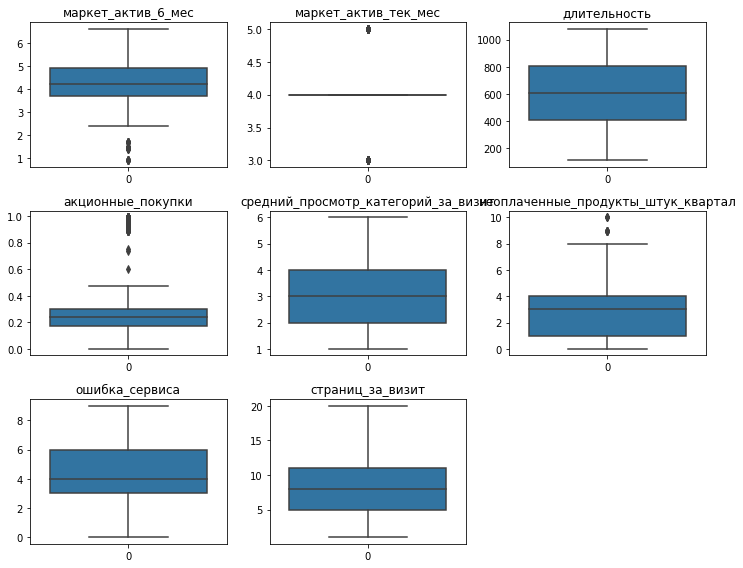

In [103]:
show_boxplots(market, numeric_columns)

In [104]:
def show_hists(df, numeric_columns):
    discrete_cols = []
    continuous_cols = []

    for col in numeric_columns:
        if df[col].nunique() < 25:
            discrete_cols.append(col)
        else:
            continuous_cols.append(col)

    num_plots = len(continuous_cols) + len(discrete_cols)
    plt.figure(figsize=(12, 9))

    for i, column in enumerate(continuous_cols, 1):
        plt.subplot((num_plots // 3) + 1, 3, i)
        sns.histplot(df[column], bins=50)
        plt.title(column)

    for i, column in enumerate(discrete_cols, len(continuous_cols) + 1):
        plt.subplot((num_plots // 3) + 1, 3, i)
        sns.countplot(x=df[column])
        plt.title(column)

    plt.tight_layout()
    plt.show()

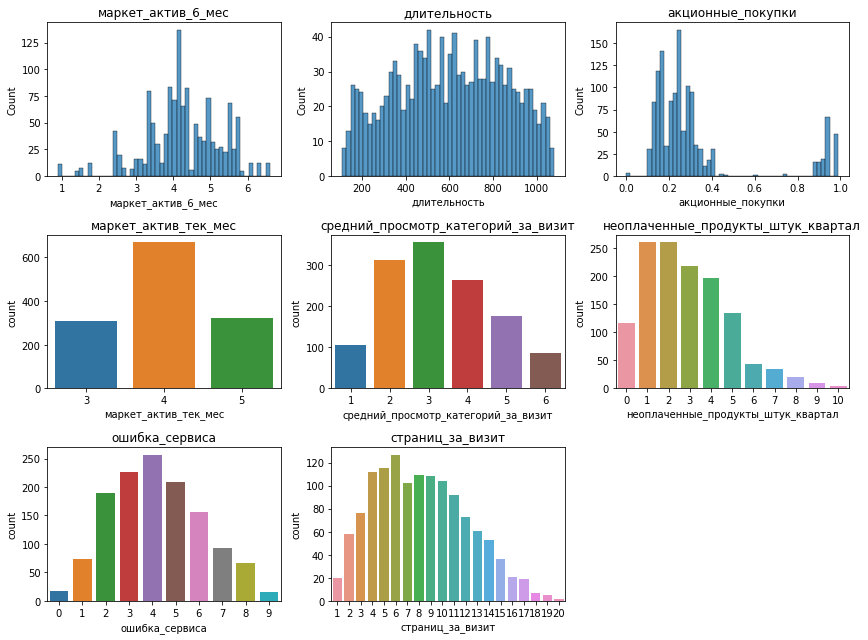

In [105]:
show_hists(market, numeric_columns)

<div class="alert alert-info">
Overall, the numerical features are fine, with no significant anomalies.

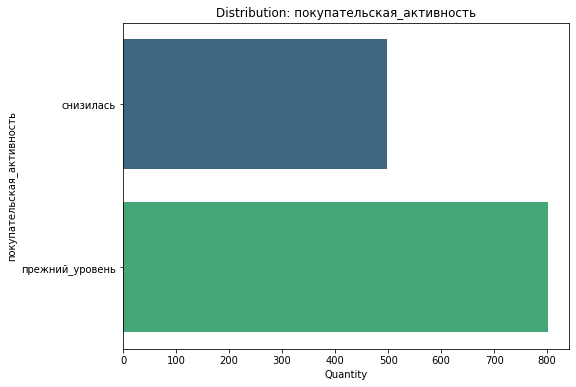

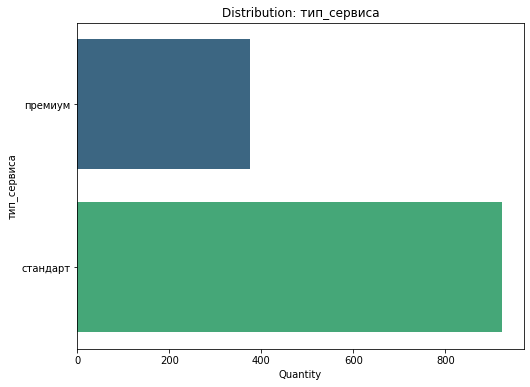

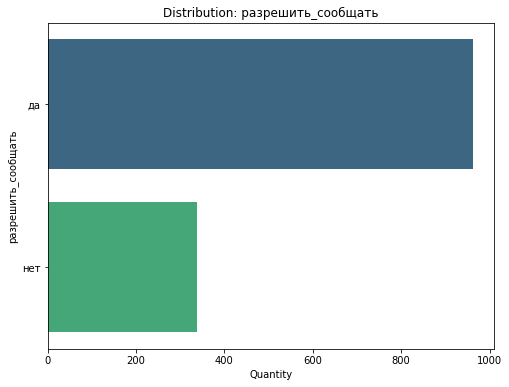

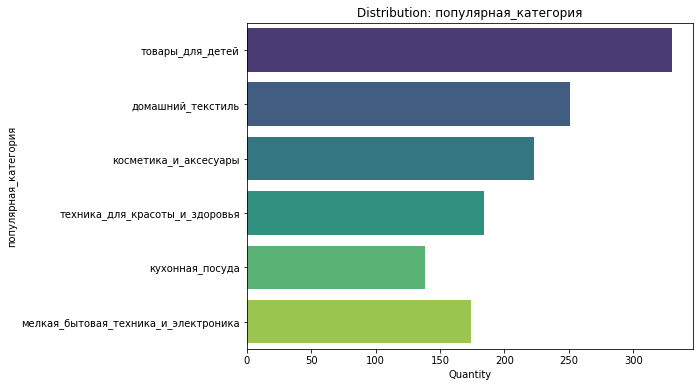

In [106]:
categorical_columns = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
for col in categorical_columns:
    plt.figure(figsize=(8,6))
    sns.countplot(y=col, data=market, palette='viridis')
    plt.title(f'Distribution: {col}')
    plt.xlabel('Quantity')
    plt.ylabel(col)
    plt.show()

In [107]:
print(market['покупательская_активность'].value_counts())

прежний_уровень    802
снизилась          498
Name: покупательская_активность, dtype: int64


<div class="alert alert-info">
The categorical features are also fine. The only issue is that the target feature "покупательская_активность" is not evenly distributed, so it will need to be considered in the model. Accuracy becomes less useful, so I will use the f1-score (after balancing).

In [108]:
print("market_money - all", market_money.shape)
market_money = market_money[market_money['выручка'] > 0]

print("market_money - with revenue", market_money.shape)
active_clients = market_money.groupby("id").count().reset_index()
active_clients = active_clients[active_clients["период"] >= 3]
print("Active clients^", active_clients.shape)

market_money - all (3899, 3)
market_money - with revenue (3893, 3)
Active clients^ (1296, 3)


In [109]:
market = market[market["id"].isin(active_clients["id"])]
market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int32  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float32
 5   маркет_актив_тек_мес                 1296 non-null   int32  
 6   длительность                         1296 non-null   int32  
 7   акционные_покупки                    1296 non-null   float32
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int32  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int32  
 11  ошибка_сервиса                

### Conclusion

<div class="alert alert-info">
Almost all customers made purchases in the last three months, and no serious anomalies are observed in the data. I’ve filtered the data, and we can now move on to merging the tables.

<a id="section_4"></a>
## Merging tables

### Preparing tables

In [110]:
money_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
money_pivot.reset_index(inplace=True)
money_pivot.columns = ['id'] + [f'выручка_{col}' for col in money_pivot.columns[1:]]
display(money_pivot.head())

,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,NaN,NaN,3293.100098
1,215349,4472.0,5216.0,4971.600098
2,215350,4826.0,5457.5,5058.399902
3,215351,4793.0,6158.0,6610.399902
4,215352,4594.0,5807.5,5872.500000


In [111]:
time_pivot = market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum')
time_pivot.reset_index(inplace=True)
time_pivot.columns = ['id'] + [f'время_{col}' for col in time_pivot.columns[1:]]
display(time_pivot.head())

,id,время_предыдущий_месяц,время_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


### Merge

In [112]:
print(f"market: {market.shape}")
print(f"money_pivot: {money_pivot.shape}")
print(f"time_pivot: {time_pivot.shape}")

market: (1296, 13)
money_pivot: (1300, 4)
time_pivot: (1300, 3)


In [113]:
market_full = market.merge(money_pivot, on='id', how='left').merge(time_pivot, on='id', how='left')
print(f"market_full: {market_full.shape}")
display(market_full.head())
market_full.info()

market_full: (1296, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.600098,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.399902,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.399902,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.500000,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5124.0,4738.5,5388.500000,10,10


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int32  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float32
 5   маркет_актив_тек_мес                 1296 non-null   int32  
 6   длительность                         1296 non-null   int32  
 7   акционные_покупки                    1296 non-null   float32
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int32  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int32  
 11  ошибка_сервиса                

### Conclusion

<div class="alert alert-info">
    
The data has been successfully merged, and now there are 17 features (excluding the ID).

<a id="section_5"></a>
## Correlation analysis

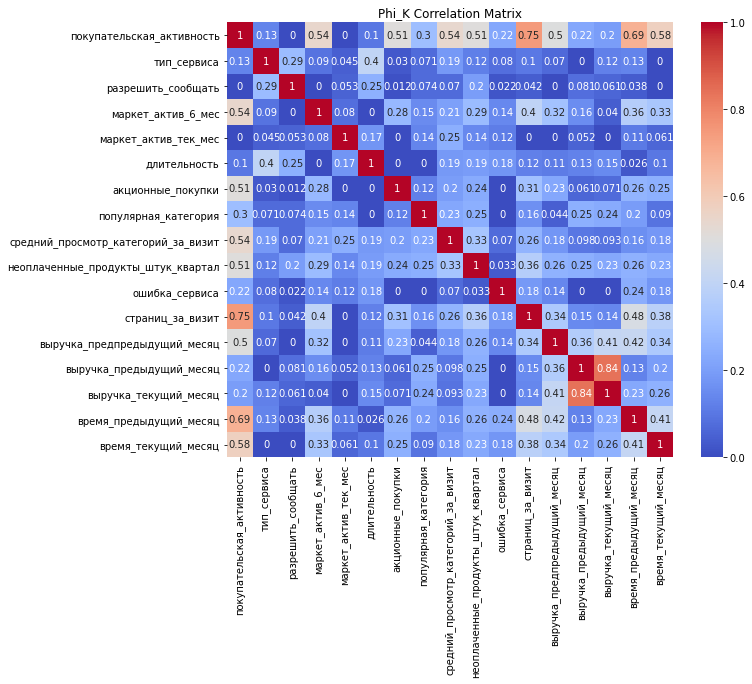

In [114]:
numeric_columns_full = market_full.drop(columns=['id']).select_dtypes(include=['float32','int32']).columns
corr_matrix = market_full.drop(columns=['id']).phik_matrix(interval_cols=numeric_columns_full)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

<div class="alert alert-info">

There is a strong correlation only between the revenue for the current month and the revenue for the previous month, with a correlation of 0.84. Since it's less than 0.9, I will not remove it.

<a id="section_6"></a>
## Using pipelines

### Data preparation

In [115]:
le = LabelEncoder()
market_full['покупательская_активность'] = le.fit_transform(market_full['покупательская_активность'])
market_full = market_full.set_index('id') ## We need to remove the ID, but we will need it later.
display(market_full.head())

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.600098,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.399902,8,13
215351,1,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.399902,11,13
215352,1,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.500000,8,11
215353,1,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5124.0,4738.5,5388.500000,10,10


In [116]:
print(market_full['покупательская_активность'].value_counts())

0    802
1    494
Name: покупательская_активность, dtype: int64


In [117]:
target = 'покупательская_активность'
RANDOM_STATE = 42

X = market_full.drop(columns=[target], axis=1)
y = market_full[target]

display(X.head())
display(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
#Don't forget the unequal distribution of the target variable.

print(X_train.shape, X_test.shape)

num_columns = X.select_dtypes(include=['number']).columns
ohe_columns = X.select_dtypes(include=['object']).drop(['тип_сервиса'], axis=1).columns
ord_columns = ['тип_сервиса']

categories_order = [['стандарт', 'премиум']]

display(num_columns)
display(ohe_columns)
display(ord_columns)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.600098,12,10
215350,стандарт,нет,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.399902,8,13
215351,стандарт,да,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.399902,11,13
215352,стандарт,нет,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.500000,8,11
215353,стандарт,да,3.3,4,762,0.26,домашний_текстиль,4,1,1,4,5124.0,4738.5,5388.500000,10,10


id
215349    1
215350    1
215351    1
215352    1
215353    1
Name: покупательская_активность, dtype: int64

(972, 16) (324, 16)


Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предпредыдущий_месяц',
       'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
       'время_предыдущий_месяц', 'время_текущий_месяц'],
      dtype='object')

Index(['разрешить_сообщать', 'популярная_категория'], dtype='object')

['тип_сервиса']

In [118]:
ohe_pipe = Pipeline([
    (
        'ohe',
        OneHotEncoder(
            drop='first',
            sparse_output=False,
            handle_unknown='ignore'
        )
    )
])

ord_pipe = Pipeline([
    (
        'ord',
        OrdinalEncoder(
            categories=categories_order,
            handle_unknown='use_encoded_value',
            unknown_value=np.nan
        )
    ),
    (
        'simple_Imputer',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    )
])

num_pipe = Pipeline([
    ('scaler1', StandardScaler()),
    ('scaler2', MinMaxScaler())
])

In [119]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### Model training

In [120]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [121]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('The best model and its parameters: \n\n', randomized_search.best_estimator_)
print('The metric of the best model based on cross-validation results:', randomized_search.best_score_)

The best model and its parameters: 

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['разрешить_сообщать', 'популярная_категория'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                       

In [122]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'The ROC-AUC metric on the test set: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')
print(f'The F1-score metric on the test set: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')

The ROC-AUC metric on the test set: 0.92
The F1-score metric on the test set: 0.9


In [123]:
best_model = randomized_search.best_estimator_.named_steps['models']
print(best_model)

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')


### Conclusion

<div class="alert alert-info">

The best model turned out to be LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'). Since we have a binary classification task, the best metric for this is ROC-AUC.

<a id="section_7"></a>
## Feature importance analysis

### Feature importance and plots

(972, 20)
(324, 20)


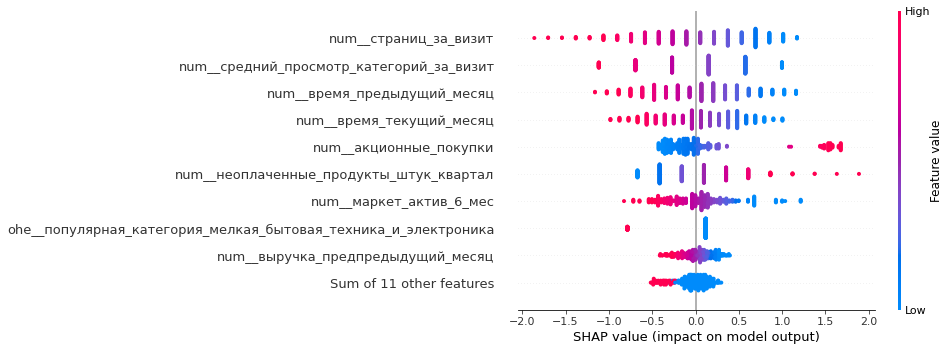

In [124]:
X_train_transformed = data_preprocessor.fit_transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

# Getting feature names after transformation
feature_names = data_preprocessor.get_feature_names_out()

# Training the best model on all training data
best_model.fit(X_train_transformed, y_train)

# Creating the Explainer object
explainer = shap.Explainer(best_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_test_transformed)

# display(shap.plots.bar(shap_values, max_display=30))
shap.plots.beeswarm(shap_values) 

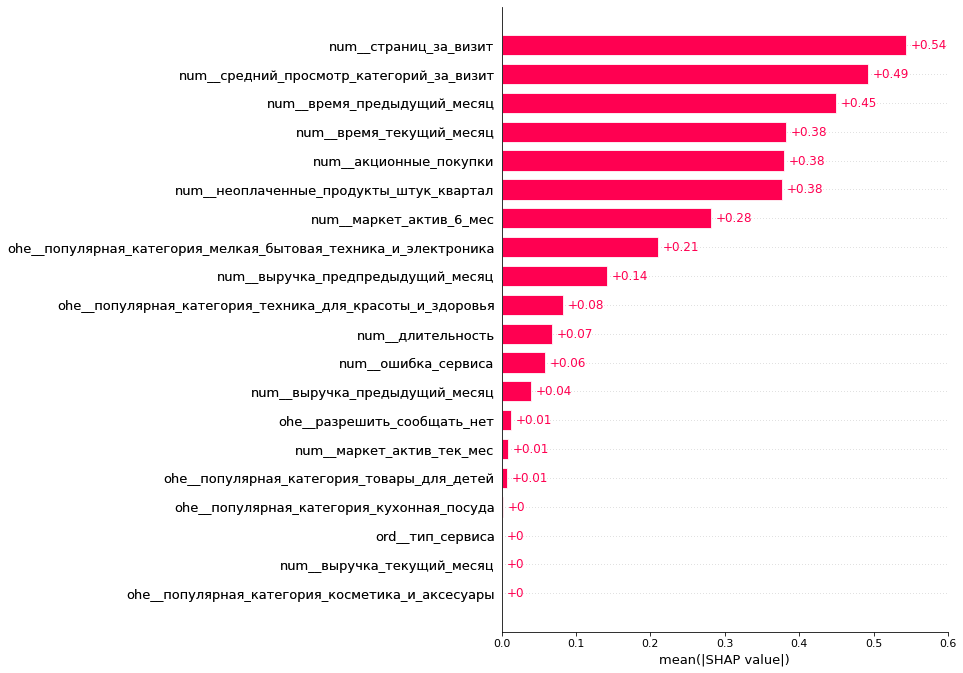

In [125]:
shap.plots.bar(shap_values, max_display=30)

### Conclustions

<div class="alert alert-info">

The most important features turned out to be: pages per visit, average category views per visit, time from the previous month, unpaid products per quarter, and time spent in the current month. Promotional purchases and marketing activity over the last 6 months are also highly influential. Overall, it seems realistic that the more time you spend actively on the site, the more engaged you are.

The least important features include: service type, revenue for the current and previous month, allowing notifications, and current month marketing activity.

When modeling and making business decisions, more attention should be paid to the UI/UX of the product, offering a wider variety of products. It's also better to focus on long-term advertising, pushing items to customers over time, as this works much better than short-term advertising.

Additionally, reducing system errors (ошибка_сервиса) would also be beneficial. Its impact isn't significant, but it's not zero either.
</div>


<a id="section_8"></a>
## Customer segmentation

### Segmentation of customers by profitability and activity

In [126]:
print(X_test.shape)
print(len(y_test_pred))
display(len(y_test_proba))

(324, 16)
324


324

In [127]:
pred_df = X_test
pred_df = pred_df.drop(columns=['тип_сервиса', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц',
                                'разрешить_сообщать', 'маркет_актив_тек_мес'])
pred_df['y_test_pred'] = y_test_pred
pred_df['y_test_proba'] = y_test_proba[:,1]

old_money = money.set_index('id')
pred_df = pred_df.join(old_money)

display(pred_df.head(10))

,маркет_актив_6_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,время_предыдущий_месяц,время_текущий_месяц,y_test_pred,y_test_proba,прибыль
id,,,,,,,,,,,,,,
216161,4.1,606,0.15,техника_для_красоты_и_здоровья,6,1,4,12,4912.0,16,17,0,0.013654,4.69
215654,1.4,684,0.94,товары_для_детей,3,6,1,6,4656.0,11,9,1,0.984846,2.75
216307,3.3,488,0.13,домашний_текстиль,4,2,8,10,4565.0,20,11,0,0.113815,3.16
215501,3.5,1057,0.35,домашний_текстиль,4,3,5,6,4993.0,9,9,1,0.756745,3.74
215934,5.5,147,0.99,мелкая_бытовая_техника_и_электроника,1,2,3,7,4451.0,15,18,1,0.521947,4.40
216576,5.8,176,0.28,домашний_текстиль,6,2,4,6,5150.0,18,15,0,0.035759,3.20
216465,4.9,739,0.17,мелкая_бытовая_техника_и_электроника,5,1,4,4,5180.0,18,15,0,0.032238,2.03
216527,4.9,679,0.15,техника_для_красоты_и_здоровья,4,1,1,14,5023.0,12,19,0,0.025860,3.26
215885,5.5,625,0.16,косметика_и_аксесуары,3,3,7,5,5326.0,13,14,0,0.268392,3.89


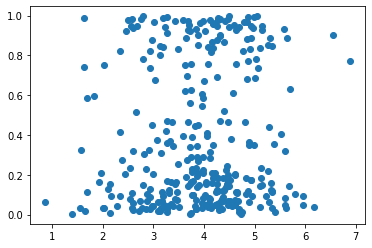

In [128]:
plt.scatter(pred_df['прибыль'], pred_df['y_test_proba']);

<div class="alert alert-info">
    
Most customers, judging by the concentration of points at the bottom, have a low chance of decreased activity. The points are distributed across the entire range, so the amount of spending is not the only factor influencing activity reduction.

### Group selection and analysis

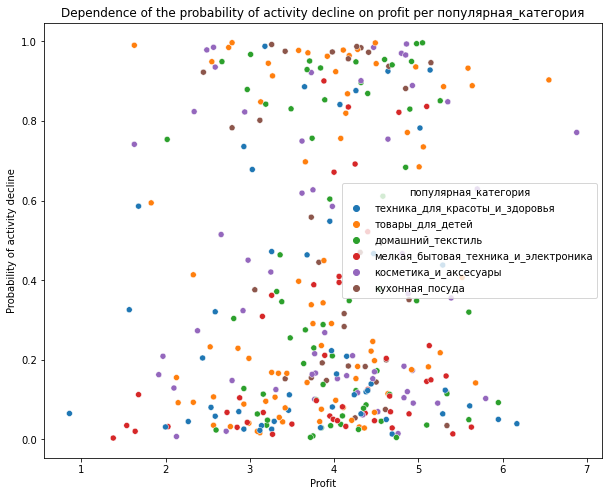

In [129]:
cat_columns = pred_df.select_dtypes(include='object').columns

for cat_col in cat_columns:
    fig = plt.figure(figsize=(10,8))
    sns.scatterplot(data=pred_df, x='прибыль', y='y_test_proba', hue=cat_col)
    plt.xlabel('Profit')
    plt.ylabel('Probability of activity decline')
    plt.title(f'Dependence of the probability of activity decline on profit per {cat_col}')
    plt.show()

<div class="alert alert-info">

Among the categorical features, only the popular category seems to have some effect, but it's hard to extract meaningful insights from the chart. I’ll proceed with the numerical ones.

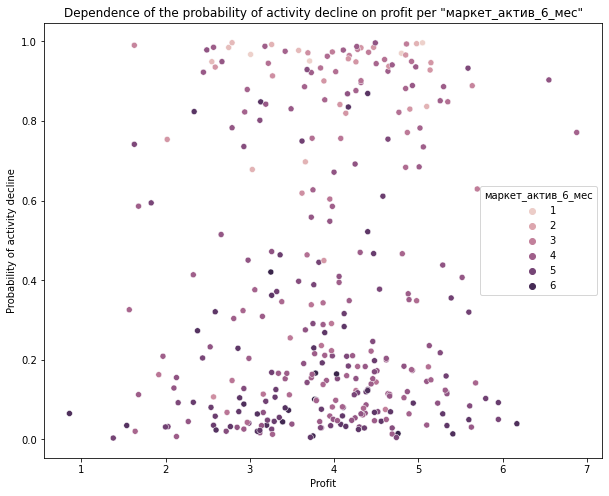

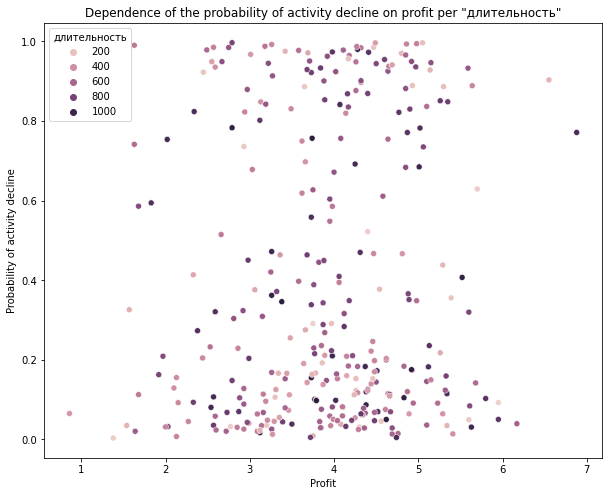

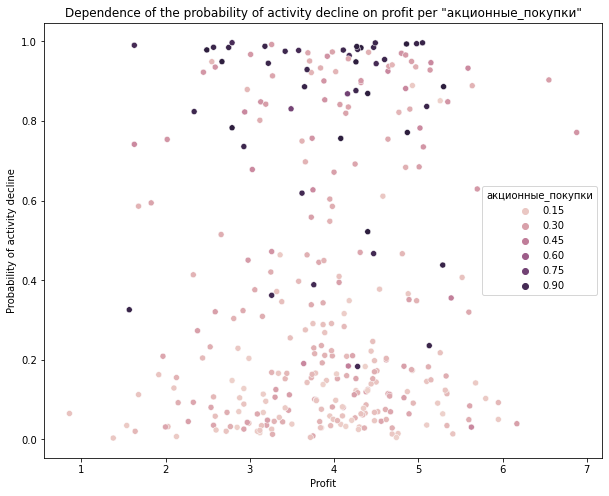

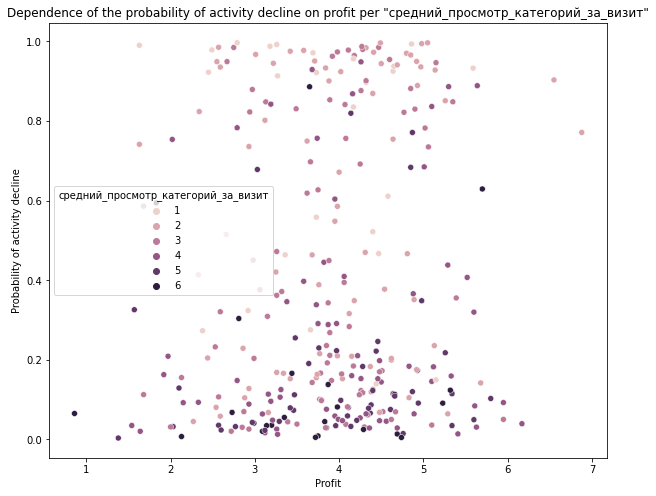

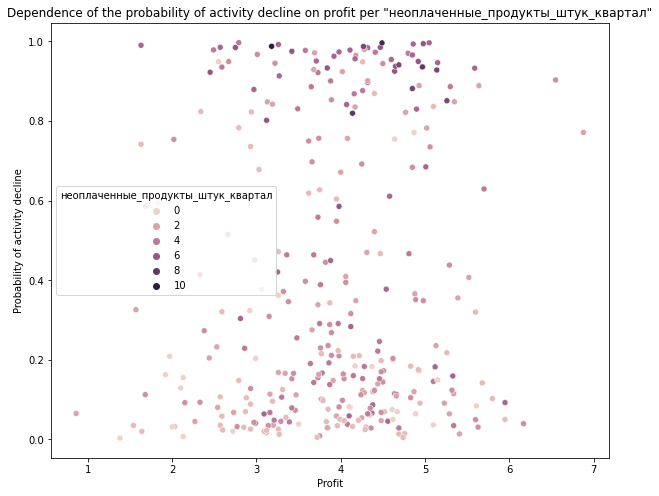

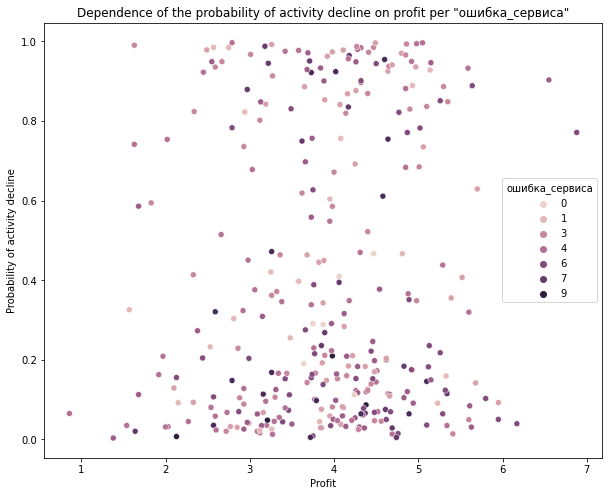

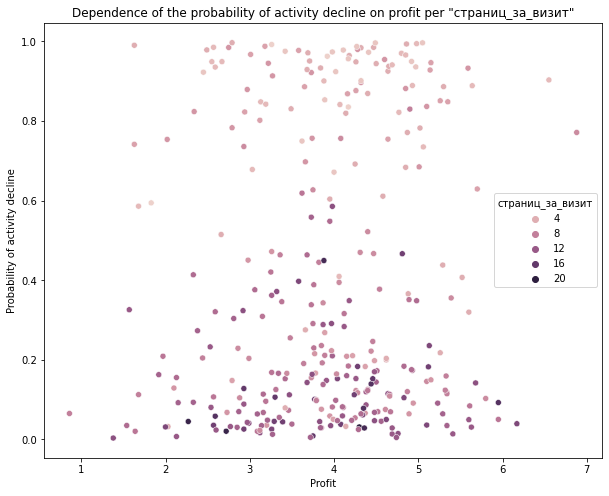

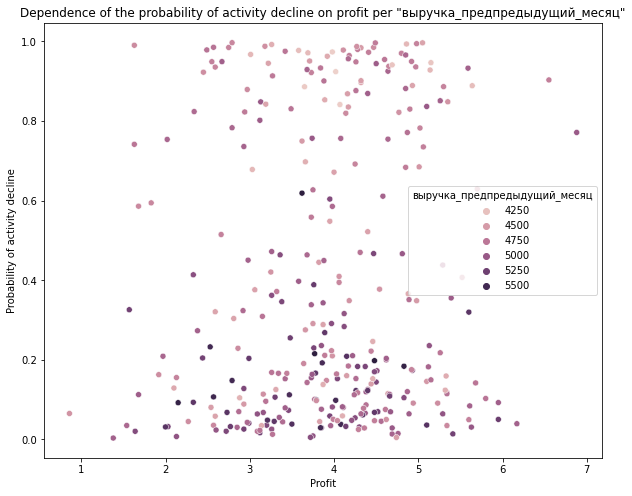

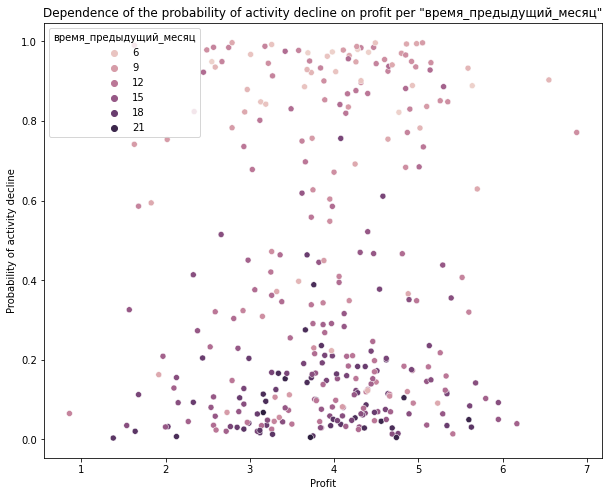

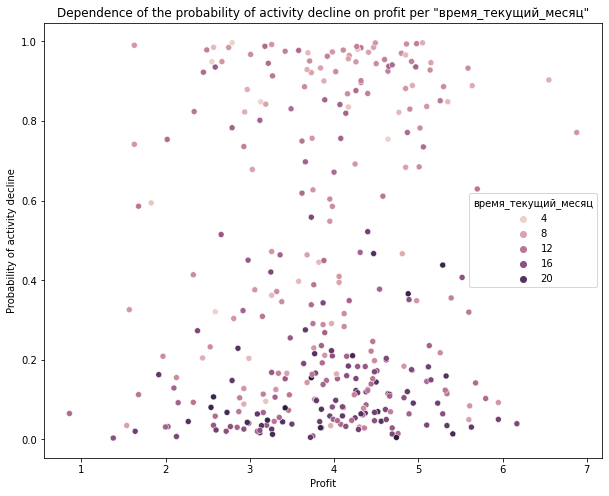

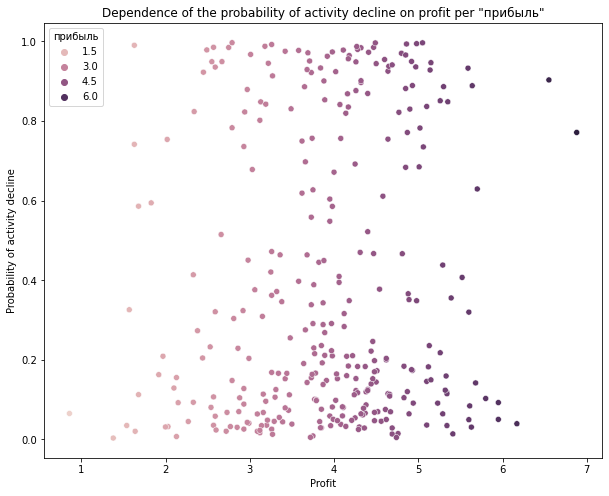

In [130]:
num_columns = pred_df.drop(columns=['y_test_proba', 'y_test_pred'], axis=1).select_dtypes(include='number').columns

for num_col in num_columns:
    fig = plt.figure(figsize=(10,8))
    sns.scatterplot(data=pred_df, x='прибыль', y='y_test_proba', hue=num_col)
    plt.xlabel('Profit')
    plt.ylabel('Probability of activity decline')
    plt.title(f'Dependence of the probability of activity decline on profit per "{num_col}"')
    plt.show()

<div class="alert alert-info">

People who make promotional purchases stand out, as well as those with low revenue from the month before last. I'll check the likelihood of their activity declining.

In [131]:
df_segment = pred_df.loc[(pred_df['акционные_покупки']>0.5) & (pred_df['выручка_предпредыдущий_месяц']<5000)]
display(df_segment.head())
print(df_segment.shape)
print(df_segment['y_test_proba'].mean())

,маркет_актив_6_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,время_предыдущий_месяц,время_текущий_месяц,y_test_pred,y_test_proba,прибыль
id,,,,,,,,,,,,,,
215654,1.4,684,0.94,товары_для_детей,3,6,1,6,4656.0,11,9,1,0.984846,2.75
215934,5.5,147,0.99,мелкая_бытовая_техника_и_электроника,1,2,3,7,4451.0,15,18,1,0.521947,4.40
215844,4.3,1041,0.99,кухонная_посуда,4,1,6,6,4880.0,9,14,1,0.783122,2.79
215375,3.0,558,0.89,товары_для_детей,3,3,7,4,4715.0,8,9,1,0.964516,4.18
215452,3.8,756,0.90,товары_для_детей,2,3,6,4,4963.0,11,10,1,0.944254,4.50


(38, 14)
0.90243729370459


<div class="alert alert-info">

Such users have a 90% chance of decreased activity, which seems like a group worth targeting.

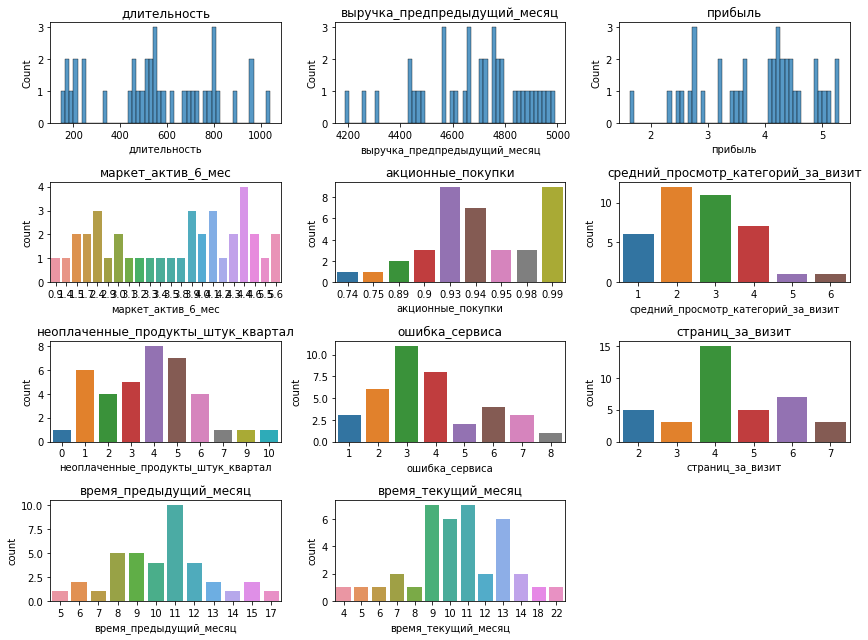

In [132]:
show_hists(df_segment, num_columns)

<AxesSubplot:xlabel='count', ylabel='популярная_категория'>

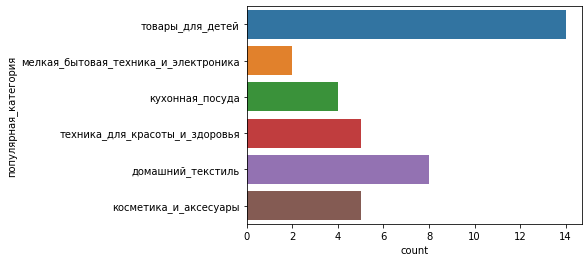

In [133]:
sns.countplot(data=df_segment, y='популярная_категория')

<div class="alert alert-info">
    
The highest number of category views per visit is 2-3, the most common number of page visits is 4, and the most important factor is the popular category—children's products (товары_для_детей). So, most likely, these are mothers visiting the site to buy specific items or categories of items on sale.

In [134]:
print(df_segment['прибыль'].mean())
print(money['прибыль'].mean())

3.879211
3.9966304


### Conclusions and Recommendations

<div class="alert alert-info">
    
For further investigation, I selected the segment of users who buy promotional items with revenue from the month before last of less than 5 thousand. This is a group of customers who are almost guaranteed (90%) to experience a decrease in activity, and it turns out that this group is likely made up of mothers buying children's products (and a little for themselves and home) on sale.

First and foremost, I would recommend not worrying too much and analyzing this group over a longer period. These might be truly loyal customers who just shop in bursts (something comes on sale every three months, they buy it, and once it's gone, they wait for the next sale). The profit difference between such customers and regular ones is negligible, so I don't think they should be considered problematic.

As for increasing the activity of these customers, I would analyze which products they buy and in which categories, and then try to offer them personalized discounts on fewer but more relevant categories for them. Perhaps some double promotions like "diapers + furniture covers". Trying to lure them into categories they’re not interested in will most likely be futile since they have a limited budget. It’s better to offer more options from what they may need and find interesting.

<a id="section_9"></a>
## Overall conclusion

### Describe the task

<div class="alert alert-info">
The task of this project was to develop a machine learning model that predicts the likelihood of customer activity decline, as well as to identify customer segments and suggest strategies for retaining them.

### Describe the source data and the preprocessing performed.

<div class="alert alert-info">

There are several datasets:
1. <b>market_file</b> - customer behavior data on the website
2. <b>market_money</b> - revenue data from the customer over the last three months
3. <b>market_time</b> - data on the time spent by the customer on the website over the last two months
4. <b>money</b> - average monthly profit per customer over the last three months

There is data for 1300 users. The data is generally good, with only minor adjustments:
1. Standardized column names to one format - lowercase letters and underscores instead of spaces
2. Converted profit values in the finance table to `float` type, and optimized all numerical values to int32/float32.
3. Standardized categorical column values to one format - lowercase letters and underscores instead of spaces.
4. Removed duplicate service type 'стандартт'. Corrected period names.

### Describe what did you do to find the best model

1. **Data Preprocessing:**
   - Encoding the target variable with **`LabelEncoder`**.
   - Splitting the data into train/test sets with consideration of class imbalance (**`stratify=y`**).
   - Distinction of feature types: **numerical, categorical, ordinal**.

2. **Configured Data Processing Pipelines:**
   - **OneHotEncoder** for nominal features.
   - **OrdinalEncoder** for ordinal features.
   - **StandardScaler + MinMaxScaler** for numerical data.

3. **Constructed the Overall Pipeline**

### Choose best model


<div class="alert alert-info">

The best model turned out to be **LogisticRegression**(C=1, penalty='l1', random_state=42, solver='liblinear'). Since it is a binary classification task, the **ROC-AUC** metric was checked on the test set: **0.92**.

### Add insights and additional offers for your selected customer segment.

<div class="alert alert-info">

The main "risk group" is a very specific category: mothers buying children's products (and a bit for themselves and their homes) on sale. I believe this is more of a good news story, as these customers are almost as profitable as others and have a stable motivation: finding a specific item at a lower price. I think, after some research, it will be possible to motivate this group to engage more regularly on the platform.

As for increasing the activity of these customers, I would analyze what products they buy and in which categories, then try to offer them personalized discounts on fewer, more relevant categories. Perhaps some double promotions like "diapers + furniture covers." Trying to lure them into categories they are not interested in would likely be pointless, as their budget is limited. It’s better to provide more options from what could be necessary and interesting to them.

Also, it might be worth considering expanding the store’s product range specifically for this audience. Perhaps they are buying other discounted items elsewhere, but could buy them here instead.